# 01 data_exploration
This notebook explores the raw dataset (financial_fraud_detection_dataset.csv) with: 
1. Setup & load data 
2. Time features (hour/day) 
3. Core stats & fraud rate 
4. Amount distributions 
5. Fraud vs non-fraud comparison 
6. Category breakdowns (type/channel/device/merchant) 
7. Temporal activity (by hour) 
8. Anomaly & velocity features 
9. Top accounts & sanity checks 
10. Sample & summary export

###  1.Setup & load data 

In [42]:
# 1) Basic imports
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 2) Make sure we can import from project root
PROJECT_ROOT = Path("..").resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# 3) Import helpers from scripts/
import scripts.utils as u
import scripts.preprocess as prep

# 4) Paths & params
RAW_PATH = PROJECT_ROOT / "data" / "raw" / "financial_fraud_detection_dataset.csv"
PROC_DIR = PROJECT_ROOT / "data" / "processed"
FIG_DIR  = PROJECT_ROOT / "reports" / "figures"
SAMPLE_SIZE = None 

PROC_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

# 5) Load (optionally sample)
assert RAW_PATH.exists(), f"Raw CSV not found at {RAW_PATH}"
df_raw = prep.load_and_sample(str(RAW_PATH), sample_size=SAMPLE_SIZE, random_state=42)

print(f"✅ Loaded: {len(df_raw):,} rows, {df_raw.shape[1]} cols | Memory: {u.memory_mb(df_raw):.1f} MB")
df_raw.head(2)


✅ Loaded: 5,000,000 rows, 18 cols | Memory: 3423.9 MB


,transaction_id,timestamp,sender_account,receiver_account,amount,transaction_type,merchant_category,location,device_used,is_fraud,fraud_type,time_since_last_transaction,spending_deviation_score,velocity_score,geo_anomaly_score,payment_channel,ip_address,device_hash
0,T100000,2023-08-22T09:22:43.516168,ACC877572,ACC388389,343.78,withdrawal,utilities,Tokyo,mobile,False,NaN,NaN,-0.21,3,0.22,card,13.101.214.112,D8536477
1,T100001,2023-08-04T01:58:02.606711,ACC895667,ACC944962,419.65,withdrawal,online,Toronto,atm,False,NaN,NaN,-0.14,7,0.96,ACH,172.52.47.194,D2622631


In [44]:
# Manual column mapping (for this dataset version)
SENDER_COL, RECEIVER_COL = "sender_account", "receiver_account"
AMOUNT_COL, FRAUD_COL, TS_COL = "amount", "is_fraud", "timestamp"
TYPE_COL, CHAN_COL, DEVICE_COL, MCHT_COL = "transaction_type", "payment_channel", "device_used", "merchant_category"

# Rename for consistency
df_std = df_raw.rename(columns={
    SENDER_COL: "sender",
    RECEIVER_COL: "receiver",
    AMOUNT_COL: "amount",
    FRAUD_COL: "is_fraud",
    TS_COL: "timestamp",
    TYPE_COL: "type",
    CHAN_COL: "payment_channel",
    DEVICE_COL: "device_used",
    MCHT_COL: "merchant_category"
})

# Identify available categorical features
CATEG_COLS = [c for c in ["type", "payment_channel", "device_used", "merchant_category"] if c in df_std.columns]

print("Columns standardized. Found categorical cols:", CATEG_COLS)
df_std.head(2)


Columns standardized. Found categorical cols: ['type', 'payment_channel', 'device_used', 'merchant_category']


,transaction_id,timestamp,sender,receiver,amount,type,merchant_category,location,device_used,is_fraud,fraud_type,time_since_last_transaction,spending_deviation_score,velocity_score,geo_anomaly_score,payment_channel,ip_address,device_hash
0,T100000,2023-08-22T09:22:43.516168,ACC877572,ACC388389,343.78,withdrawal,utilities,Tokyo,mobile,False,NaN,NaN,-0.21,3,0.22,card,13.101.214.112,D8536477
1,T100001,2023-08-04T01:58:02.606711,ACC895667,ACC944962,419.65,withdrawal,online,Toronto,atm,False,NaN,NaN,-0.14,7,0.96,ACH,172.52.47.194,D2622631


### – Why standardize column names?

Different versions of the dataset sometimes use different names  
(e.g. `sender_account` vs. `nameOrig`).  
To make my code easier to run later, I rename the columns into a consistent set  
like `sender`, `receiver`, `amount`, `is_fraud`.  

This does not change the original data, it just gives me a cleaner copy (`df_std`)  
so I don’t have to worry about column name mismatches in the rest of the notebook.


### Step 2 – Time features (hour/day)

In [48]:
# Make time features consistently: hour_of_day & day_of_week
if "timestamp" in df_std.columns:
    ts = pd.to_datetime(df_std["timestamp"], errors="coerce")
    df_std["hour_of_day"] = ts.dt.hour
    df_std["day_of_week"] = ts.dt.dayofweek   # 0=Mon ... 6=Sun
elif "step" in df_std.columns:
    # PaySim style: 1 step = 1 hour
    step_i = pd.to_numeric(df_std["step"], errors="coerce").fillna(0).astype(int)
    df_std["hour_of_day"] = (step_i % 24).astype(int)
    df_std["day_of_week"] = (step_i // 24 % 7).astype(int)  # nearly weekdays


# check
print(df_std[["hour_of_day","day_of_week"]].head())


   hour_of_day  day_of_week
0          9.0          1.0
1          1.0          4.0
2         11.0          4.0
3          6.0          1.0
4          8.0          6.0




We created two new columns from the raw timestamp:

- **hour_of_day (0–23)** → which hour in the day the transaction happened  
- **day_of_week (0=Monday … 6=Sunday)** → which weekday it belongs to  

Why is this useful?  
Fraud and scam activities are often not random in time.  
For example, fraudsters may prefer:
- late-night hours (when fewer staff monitor systems), or  
- weekends (when customers are less likely to check accounts).  

By extracting these simple features, we can later plot fraud vs non-fraud transactions by hour/day.  
This helps us spot temporal patterns and could be used as additional predictors in machine learning or ABM simulations.  


### Step 3 – Core stats & fraud rate

- Rows: 5M transactions, 22 columns  
- Amounts: median ≈ 139, mean ≈ 359, max ≈ 3520 → distribution is skewed  
- Fraud rate: ~3.6% (synthetic dataset, higher than real-world data)  

This gives us a quick big-picture view before deeper exploration.  


In [49]:
# Step 3 – Core stats & fraud rate

stats = {
    "n_rows": len(df_std),
    "n_cols": df_std.shape[1],
    "n_senders": df_std[SENDER_COL].nunique() if SENDER_COL in df_std else None,
    "n_receivers": df_std[RECEIVER_COL].nunique() if RECEIVER_COL in df_std else None,
    "amount_min": float(df_std[AMOUNT_COL].min()),
    "amount_median": float(df_std[AMOUNT_COL].median()),
    "amount_mean": float(df_std[AMOUNT_COL].mean()),
    "amount_max": float(df_std[AMOUNT_COL].max()),
}

# Fraud rate (if available)
if FRAUD_COL is not None:
    stats["fraud_rate"] = float(pd.to_numeric(df_std[FRAUD_COL], errors="coerce").mean())

pd.Series(stats)


n_rows           5.000000e+06
n_cols           2.200000e+01
n_senders                 NaN
n_receivers               NaN
amount_min       1.000000e-02
amount_median    1.386700e+02
amount_mean      3.589343e+02
amount_max       3.520570e+03
fraud_rate       3.591060e-02
dtype: float64

### Step 4 – Amount distributions

We plot the distribution of transaction amounts to see scale and skew.  
Fraud vs non-fraud is shown separately: this helps check if fraudsters prefer certain ranges (e.g. mid-range or larger transfers).  


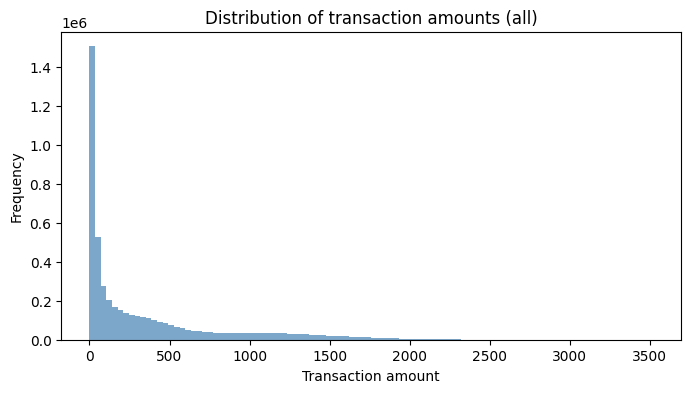

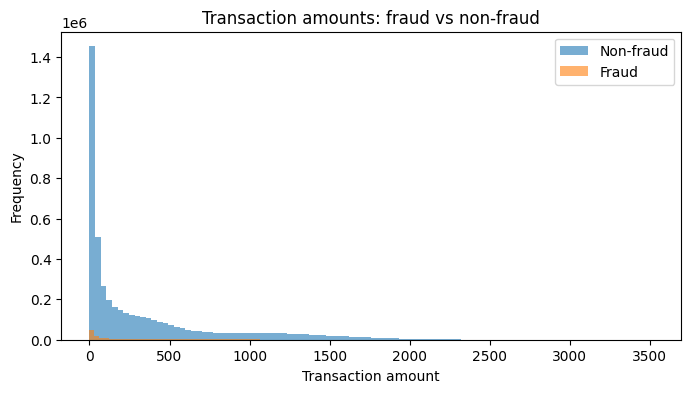

In [50]:
# Step 4 – Amount distributions

plt.figure(figsize=(8,4))
df_std[AMOUNT_COL].plot(kind="hist", bins=100, alpha=0.7, color="steelblue")
plt.xlabel("Transaction amount")
plt.ylabel("Frequency")
plt.title("Distribution of transaction amounts (all)")
plt.show()

# Fraud vs non-fraud comparison (if label available)
if FRAUD_COL is not None:
    plt.figure(figsize=(8,4))
    df_std[df_std[FRAUD_COL]==0][AMOUNT_COL].plot(kind="hist", bins=100, alpha=0.6, label="Non-fraud")
    df_std[df_std[FRAUD_COL]==1][AMOUNT_COL].plot(kind="hist", bins=100, alpha=0.6, label="Fraud")
    plt.xlabel("Transaction amount")
    plt.ylabel("Frequency")
    plt.title("Transaction amounts: fraud vs non-fraud")
    plt.legend()
    plt.show()




- Most transactions are very small, with a long tail up to a few thousand.  
- Fraudulent transactions (orange) are also concentrated at the **small-amount range**, instead of at very large amounts.  
- This suggests that attackers may use **many small transfers** (e.g., smurfing) to avoid detection, rather than a few obvious big ones.  
- Research value: amount alone is not enough to flag fraud, but observing this pattern motivates combining amount with **frequency, network connections, and timing** for better detection.  


Fraud amount stats:
 count    179553.000000
mean        358.528199
std         469.531257
min           0.010000
25%          26.480000
50%         137.880000
75%         501.720000
max        3128.140000
Name: amount, dtype: float64

Non-fraud amount stats:
 count    4.820447e+06
mean     3.589494e+02
std      4.699483e+02
min      1.000000e-02
25%      2.657000e+01
50%      1.387100e+02
75%      5.039600e+02
max      3.520570e+03
Name: amount, dtype: float64


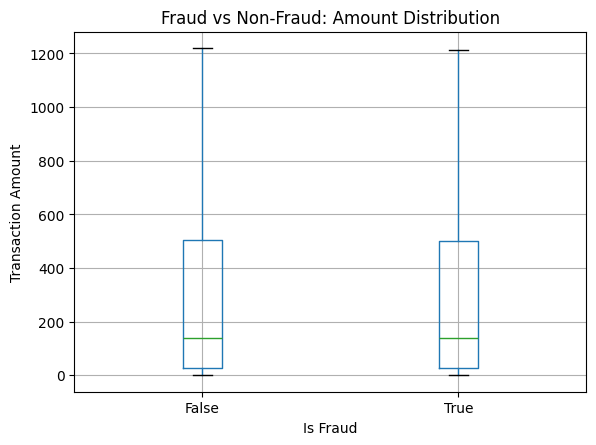

In [51]:
# 5. Fraud vs Non-Fraud comparison

if FRAUD_COL is not None:
    # simple describe
    fraud_stats = df_std[df_std[FRAUD_COL] == 1][AMOUNT_COL].describe()
    nonfraud_stats = df_std[df_std[FRAUD_COL] == 0][AMOUNT_COL].describe()
    print("Fraud amount stats:\n", fraud_stats)
    print("\nNon-fraud amount stats:\n", nonfraud_stats)

    # quick boxplot
    df_std.boxplot(column=AMOUNT_COL, by=FRAUD_COL, showfliers=False)
    plt.title("Fraud vs Non-Fraud: Amount Distribution")
    plt.suptitle("")
    plt.xlabel("Is Fraud")
    plt.ylabel("Transaction Amount")
    plt.show()


Transaction amounts alone do not provide strong separation between fraud and non-fraud. This suggests the need to incorporate additional features such as frequency, network structure, or device/channel information.

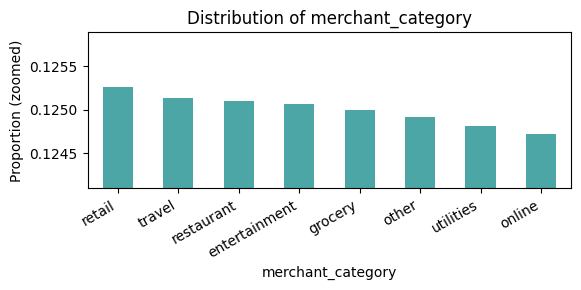

In [58]:
col = "merchant_category"
counts = df_std[col].value_counts(normalize=True)[:10]
plt.figure(figsize=(6,3))
ax = counts.plot(kind="bar", color="teal", alpha=0.7)
ymin = counts.min() * 0.995
ymax = counts.max() * 1.005
ax.set_ylim(ymin, ymax)
plt.title(f"Distribution of {col}")
plt.ylabel("Proportion (zoomed)")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()


- The merchant and channel categories look very even — every type (like retail, travel, grocery, etc.) has almost the same share.
- This is probably because the dataset is synthetic, meaning it was created by simulation instead of real bank data.
- In real life, we would expect more transactions in some categories (for example, “online” or “retail”), and maybe more fraud in those groups too.
- So this step doesn’t show strong patterns, but it’s still useful to check that these columns are clean and ready for later analysis or modelling.

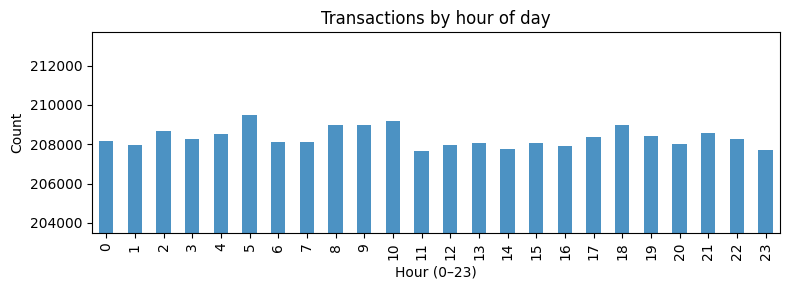

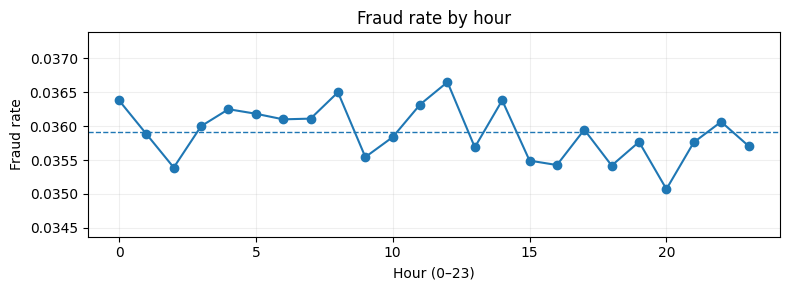

,count,fraud_rate
hour_of_day,,
0,208141,0.036379
1,207952,0.035883
2,208680,0.035389
3,208256,0.035999
4,208532,0.036249


In [ ]:
# Step 7.1 — Fraud rate by hour (zoomed y-axis)

hour_col = (
    "hour_of_day" if "hour_of_day" in df_std.columns
    else ("hour" if "hour" in df_std.columns else None)
)

if (hour_col is None) or (FRAUD_COL is None) or (FRAUD_COL not in df_std.columns):
    print("Missing hour or fraud label; skip fraud-by-hour.")
else:
    # make sure fraud is binary 0/1
    y = pd.to_numeric(df_std[FRAUD_COL], errors="coerce").fillna(0).astype(int)

    # crosstab for counts by hour x {0,1}; reindex to ensure all 24 hours show up
    ct = pd.crosstab(df_std[hour_col], y)
    if 0 not in ct.columns: ct[0] = 0
    if 1 not in ct.columns: ct[1] = 0
    ct = ct[[0, 1]].sort_index()
    ct = ct.reindex(range(24), fill_value=0)

    total = ct.sum(axis=1).replace(0, np.nan)
    fraud_rate_by_hour = (ct[1] / total).fillna(0)

    # --- Plot 1: hourly counts (zoomed y-axis)
    ax = ct.sum(axis=1).plot(kind="bar", figsize=(8,3), alpha=0.8)
    ax.set_title("Transactions by hour of day")
    ax.set_xlabel("Hour (0–23)")
    ax.set_ylabel("Count")
    ymin, ymax = ct.sum(axis=1).min()*0.98, ct.sum(axis=1).max()*1.02
    ax.set_ylim(ymin, ymax)
    plt.tight_layout()
    plt.show()

    # --- Plot 2: fraud rate by hour (zoomed y-axis)
    plt.figure(figsize=(8,3))
    plt.plot(fraud_rate_by_hour.index, fraud_rate_by_hour.values, marker="o")
    plt.title("Fraud rate by hour")
    plt.xlabel("Hour (0–23)")
    plt.ylabel("Fraud rate")

    fr_min, fr_max = fraud_rate_by_hour.min(), fraud_rate_by_hour.max()
    plt.ylim(fr_min*0.98, fr_max*1.02)   # zoom
    # optional: mean line for reference
    plt.axhline(fraud_rate_by_hour.mean(), linestyle="--", linewidth=1)
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()

    # small preview table (optional)
    display(pd.DataFrame({
        "count": ct.sum(axis=1),
        "fraud_rate": fraud_rate_by_hour
    }).head())
